In [1]:
# Import Libraries
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, keras_tuner as kt, tensorflow as tf
import os, datetime, progressbar
import tensorflow_probability as tfp

tfd = tfp.distributions

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint#, TensorBoard                                                                      
from keras import backend as K
from livelossplot import PlotLossesKeras

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hypermodel import HyperModel
from keras_tuner.engine.hyperparameters import HyperParameters
#from tensorboard.plugins.hparams import api as hp                                                                             
#from keras.utils.generic_utils import get_custom_objects                                                                      

import gc
gc.enable()

hp = HyperParameters()
plotlosses = PlotLossesKeras()

In [1]:
pwd

'/Users/tashaleebillings/Desktop/Tasha_Desktop/ThesisResearch/ML/notebooks'

In [2]:
toy_model = np.load('toy_models_128x128.npz')
nx, ny, ntrain = toy_model['training_data'].shape
training_data = toy_model['training_data'].T
labels = toy_model['labels']
outputdir = "./"
project_name='toy_model_tuner'

HP_EPOCH = 30
HP_BATCH_SIZE = 5
factor = 100
num_models = 25

In [3]:
X_train = training_data[0:8000,:,:].reshape(8000,nx,ny,1)
y_train = labels[0:8000]*factor
X_test = training_data[8000:,:,:].reshape(2000,nx,ny,1)
y_test = labels[8000:]*factor

print("training", X_train.shape)
print("validation", X_test.shape)

NUM_TRAIN_EXAMPLES = len(training_data)
kl_divergence_function = (
lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(NUM_TRAIN_EXAMPLES,dtype=tf.float32)
)

training (8000, 128, 128, 1)
validation (2000, 128, 128, 1)


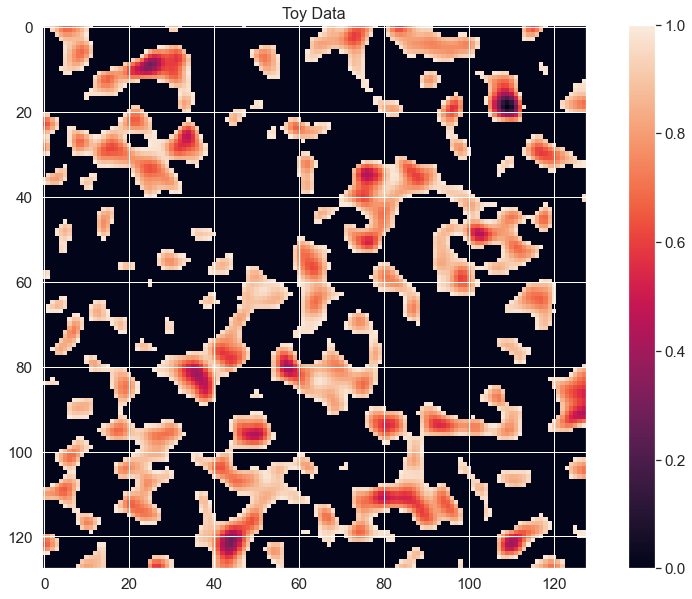

In [48]:
plt.figure(figsize=(15, 10))
plt.imshow(X_train[0,:,:,0])
plt.title("Toy Data",size = 16 )
plt.colorbar()
#plt.legend()

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


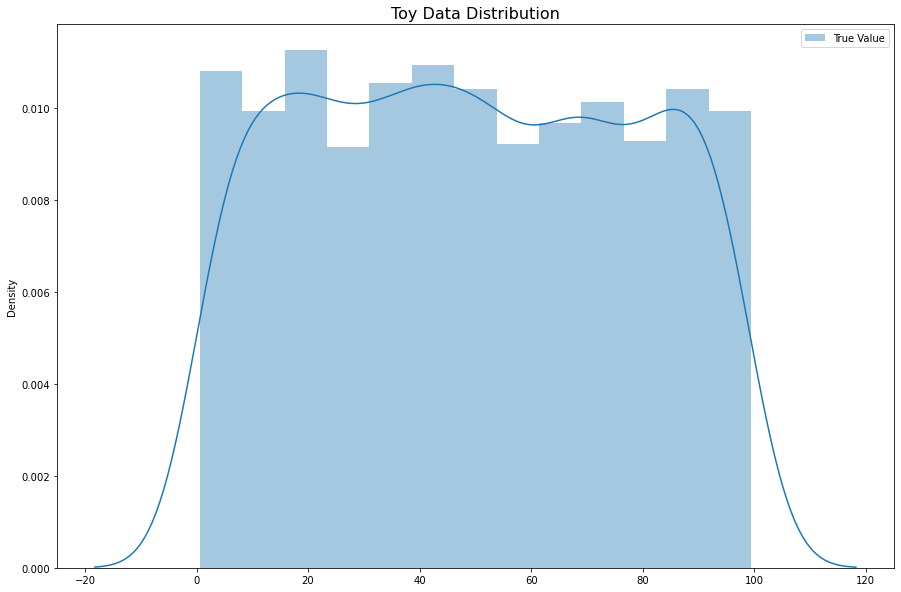

In [4]:
plt.figure(figsize=(15, 10))
sns.distplot(y_test,label="True Value")
plt.title("Toy Data Distribution",size = 16 )
#plt.xlim([0, 1.25])
plt.legend()

In [5]:
# Custom Loss Functions                                                                                                               
kl_divergence = tf.keras.losses.KLDivergence()

neg_log_likelihood = lambda y_true, y_pred: -tf.reduce_mean(input_tensor=y_pred.log_prob(y_true))

def Mean_Squared_over_true_Error(y_true, y_pred):
    # Create a custom loss function that divides the difference by the true                                                           

    y_true = K.cast(y_true, y_pred.dtype) #Casts a tensor to a different dtype and returns it.                                        
    diff_ratio = K.square((y_pred - y_true)/K.clip(K.abs(y_true),K.epsilon(),None))

    loss = K.mean(diff_ratio, axis=-1)

    # Return a tensor                                                                                                                 
    return loss

def elbo(y_true, y_pred):
    kl_weight = 1
    neg_log_likelihood = -tf.reduce_mean(input_tensor=y_pred.log_prob(y_true))
    kl_divergence = tf.keras.losses.KLDivergence()

    elbo_loss = -tf.math.reduce_mean(-kl_weight * kl_divergence(y_true, y_pred.mean()) - neg_log_likelihood)
    # Return a tensor                                                                                                                 
    return elbo_loss

def mean_fractional_error(y_true, y_pred):
    y_true = K.cast(y_true, y_pred.dtype) #Casts a tensor to a different dtype and returns it.
    diff_ratio = (y_pred - y_true)/K.clip(K.abs(y_true),K.epsilon(),None)
    loss = K.mean(diff_ratio, axis=-1)
    
    return loss

keras.utils.get_custom_objects().update({'Mean_Squared_over_true_Error':Mean_Squared_over_true_Error,
                                        'neg_log_likelihood': neg_log_likelihood, 'kl_divergence':kl_divergence,
                                        'elbo':elbo})
    

In [6]:
"""
def read_results(truth, prediction=predictions):

    #read in file
    result=np.load(filename)
    truth = (result["truth"][:]/factor)[:5*20]
    prediction = (result["prediction"][:]/factor)[:5*20]

    return [truth, prediction]

"""
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)

    # mean of x and y vector
    m_x, m_y = np.mean(x), np.mean(y)

    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x

    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x

    return [b_0, b_1]
    
def plot_regression(x, y, b, labelname):
    # plotting the actual points as scatter plot
    plt.figure(figsize=(15,15))
    plt.title(labelname)
    plt.scatter(x,y, s=6, lw=0, alpha=0.9)

    # predicted response vector
    y_pred = b[0] + b[1]*x

    # plotting the regression line
    plt.plot(x, y_pred, 'k--',lw=5,alpha=1.0)
    
    # Plot trendline
    xx = np.linspace(0.95*np.min(x), 1.05*np.max(x), 1000)
    plt.plot(xx, xx, 'r--',lw=5,alpha=1.0)

    # putting labels
    plt.xlabel('True Optical Depth', size = 16)
    plt.ylabel('Prediction', size=16)
    
    #plt.legend(markerscale=2.5)
    plt.tight_layout()

    # Save plot
    #plt.savefig(outputdir+"residual_{}.png".format(str(fold)))
    #plt.clf()

# Plot Slope and y-intercept distribution
def statistics_plot_coef(coefficient):
    coefficients = np.array(coefficient,dtype=np.float64)
    plt.plot(np.arange(1,11),coefficients,'o')
    mean_value = np.mean(coefficients,axis=0)
    mean = np.zeros_like(coefficients)
    mean[:,0]=mean_value[0]
    mean[:,1]=mean_value[1]
    plt.plot(np.arange(1,11),mean,'k--',lw=1,markersize=4)
    plt.text(5.0, 0.2, r'$\mu$ vector [b_0 , b_1]: '+str(mean_value),
            {'color': 'blue', 'fontsize': 10, 'ha': 'center', 'va': 'center',
            'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
            
    plt.xlabel("Fold Number")
    plt.ylabel("Distance from Mean")
    plt.savefig(outputdir+"bestmodel_residual_of_mean.png")
    plt.clf()

# Plot values of the deviation from the mean
def statistics_plot_dev(coefficient):
    coefficients = np.array(coefficient,dtype=np.float64)

    plt.figure(figsize=(13,8))
    plt.plot(np.arange(1,11),coefficients,'o')
    mean_value = np.mean(coefficients,axis=0)
    mean = np.zeros_like(coefficients)
    mean[:,0]=mean_value[0]
    mean[:,1]=mean_value[1]
    plt.plot(np.arange(1,11),mean,'k--',lw=1,markersize=4)
    plt.text(5.0, 0.2, r'$\mu$ vector [b_0 , b_1]: '+str(mean_value),
            {'color': 'blue', 'fontsize': 10, 'ha': 'center', 'va': 'center',
            'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
    for indx, coef in enumerate(coefficients[:,1]):
        diff = (coef-mean_value[1])/2
        plt.vlines(indx+1,coef,mean_value[1],colors='r',linestyles= 'dashed')
        plt.text(indx+1.25, coef-diff, r'%.2f' % diff,
        {'color': 'red', 'fontsize': 10, 'ha': 'center', 'va': 'center'})

    plt.xlabel("Fold Number")
    plt.ylabel("Distance from Mean")
    plt.savefig(outputdir+"bestmodel_residual_of_mean_dev.png")
    plt.clf()

def main(x, y, labelname):
    # Read in observations
    #x = read_results(filename)[0]
    #y = read_results(filename)[1]

    # estimating coefficients
    b = estimate_coef(x, y)
    coefficients.append(b)
    print("Estimated coefficients:\nb_0 = {} \
        \nb_1 = {}".format(b[0], b[1]))
        
    # write the coefficients to some text file
    fp.write(str(b)+"\n")

    # plotting regression line
    plot_regression(x, y, b, labelname)
    return


# Monte Carlo 

### Summary of Technique

Below I optimize a model that has a *fixed* architecture and *different* number training parameters but loss function.  



In [7]:
if os.path.isdir(project_name): # check to see if path exists
    os.system("rm -rvf {}".format(project_name))

def train_test_model(hp):
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 16, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 8, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    
    #for l in range(hp.Int('loss', 0, len(losses))):
    model.compile(optimizer= "adam", loss = hp.Choice('loss_type', ["mse", "mae", "mape", "Mean_Squared_over_true_Error"], ordered=False, default="mse"), metrics=["mse"])
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())
    
    return model#, history
                                                                                                                                                                                      
#model = train_test_model(hp)
# Start Tuning based on low validation loss
tuner = RandomSearch(train_test_model,
                     objective='val_loss', # 'loss', 'val_loss', 'val_accuracy'
                     max_trials= num_models,# specify the number of different models to try
                     executions_per_trial=1, #2,
                     directory=outputdir,
                     seed=42,
                     project_name=project_name)

# Print a summary of the search space
tuner.search_space_summary()

# Show the best models, their hyperparameters, and the resulting metrics.
tuner.search(X_train, y_train, 
             epochs=5,#hp.Int('epoch',min_value=10,max_value=HP_EPOCH,step=10,default=10), 
             validation_data=(X_test, y_test),
             batch_size=HP_BATCH_SIZE,
            #callbacks=[plotlosses],
            verbose=1)
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Save best hyperperam Model
print("saving best hyperparameter model ...")
best_model.save(outputdir+"hyperParam_model.h5")

# Save best hyperperam Model Weights
print("saving best hyperparameter model weights ...")
best_model.save_weights(outputdir+"hyperParam_model_weights.h5")


# Save all other models so that we can see how the model behaves based on complexity
for indx in np.arange(len(tuner.get_best_models(num_models=20))):
    model_ = tuner.get_best_models(num_models=num_models)[indx]
    # Save Model weights
    model_.save_weights(outputdir+"hyperParam_weights_{}.h5".format(str(indx+1)))
    print("Saving ... "+outputdir+"hyperParam_weights_{}.h5".format(str(indx+1)))
    # Save Model
    model_.save(outputdir+"hyperParam_model_{}.h5".format(str(indx+1)))
    print("Saving ... "+outputdir+"hyperParam_model_{}.h5".format(str(indx+1)))




Trial 4 Complete [00h 11m 42s]
val_loss: 15.080633163452148

Best val_loss So Far: 5.218881607055664
Total elapsed time: 00h 48m 02s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./toy_model_tuner_1
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: Mean_Squared_over_true_Error
Score: 5.218881607055664
Trial summary
Hyperparameters:
loss_type: mae
Score: 15.080633163452148
Trial summary
Hyperparameters:
loss_type: mape
Score: 24.86427879333496
Trial summary
Hyperparameters:
loss_type: mse
Score: 29.37200927734375
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
______________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None
Saving ... ./hyperParam_weights_3.h5
Saving ... ./hyperParam_model_3.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Con

Saving ... ./hyperParam_weights_4.h5
Saving ... ./hyperParam_model_4.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Con

IndexError: list index out of range

In [ ]:
# print best performing model's loss function
tuner.get_best_models(num_models=1)[0].loss

In [ ]:
# List of losses: the quantity that a model should seek to minimize during training.
tuner.get_best_models(num_models=1)[0].losses

In [8]:
tuner.get_best_models(num_models=20)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________

In [9]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
loss_type (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae', 'mape', 'Mean_Squared_over_true_Error'], 'ordered': False}


In [10]:
tuner.results_summary()

Results summary
Results in ./toy_model_tuner_1
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
loss_type: Mean_Squared_over_true_Error
Score: 5.218881607055664
Trial summary
Hyperparameters:
loss_type: mae
Score: 15.080633163452148
Trial summary
Hyperparameters:
loss_type: mape
Score: 24.86427879333496
Trial summary
Hyperparameters:
loss_type: mse
Score: 29.37200927734375


In [11]:
bestmodel=tuner.get_best_models(num_models=1)[0]#.predict(X_test)
pred = []

for i in range(500):
    y_p = bestmodel.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    pred.append(y_p)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None


/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

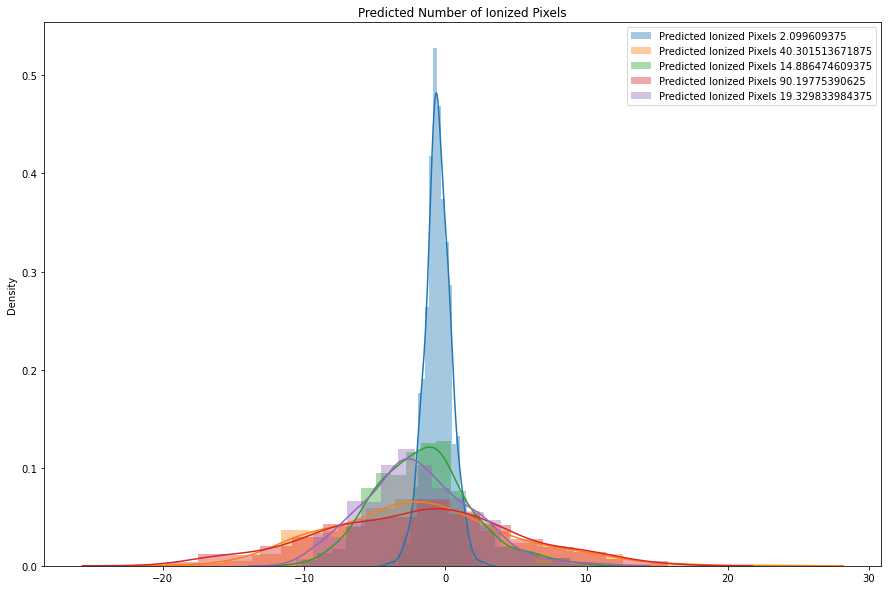

In [12]:
plt.figure(figsize=(15, 10))
plt.title("Predicted Number of Ionized {}".format("Pixels",size = 16 ))

sns.distplot(np.array(pred)[:,0]-y_test[0],label="Predicted Ionized Pixels {}".format(str(y_test[0])))
sns.distplot(np.array(pred)[:,1]-y_test[1],label="Predicted Ionized Pixels {}".format(str(y_test[1])))
sns.distplot(np.array(pred)[:,2]-y_test[2],label="Predicted Ionized Pixels {}".format(str(y_test[2])))
sns.distplot(np.array(pred)[:,3]-y_test[3],label="Predicted Ionized Pixels {}".format(str(y_test[3])))
sns.distplot(np.array(pred)[:,4]-y_test[4],label="Predicted Ionized Pixels {}".format(str(y_test[4])))

#plt.xlim([0, 1.25])
plt.legend(markerscale=2.5)

In [13]:
np.array(pred)[:,0]

array([ 1.6695986 ,  3.2860816 ,  2.4791296 ,  0.14272487,  2.6728876 ,
        2.2376585 ,  2.970044  ,  2.13507   ,  2.0114882 ,  1.4637513 ,
        2.2892969 ,  2.4713304 ,  0.5873572 ,  0.9069575 , -1.1292136 ,
        1.8795857 ,  2.3961525 ,  2.238241  ,  1.9270248 ,  1.6825104 ,
        1.2776794 ,  1.5187098 ,  1.0089874 ,  1.269248  ,  1.7733192 ,
        1.3426287 ,  2.4213672 ,  1.013843  ,  0.3237406 , -1.7593107 ,
       -0.3314594 ,  1.4153891 ,  1.4893279 ,  1.4088378 ,  1.5971203 ,
        2.8789577 ,  2.203224  ,  1.3202922 ,  1.3033934 ,  0.8044005 ,
        1.538975  ,  1.8221769 ,  2.2739346 ,  1.3967617 ,  2.4970276 ,
        1.0639639 ,  1.9629953 ,  2.1455684 ,  0.7431806 ,  1.5381838 ,
        1.3403819 ,  2.446352  ,  0.5792303 ,  2.4497108 ,  0.05311054,
        1.8500228 ,  1.3651338 ,  2.6330495 , -0.6775636 ,  1.6401141 ,
        2.0021236 ,  1.8514526 , -0.5907516 ,  1.9760168 ,  1.1611177 ,
        0.6902973 ,  1.4427836 ,  0.8206604 ,  2.4645905 ,  0.93

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None


/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________

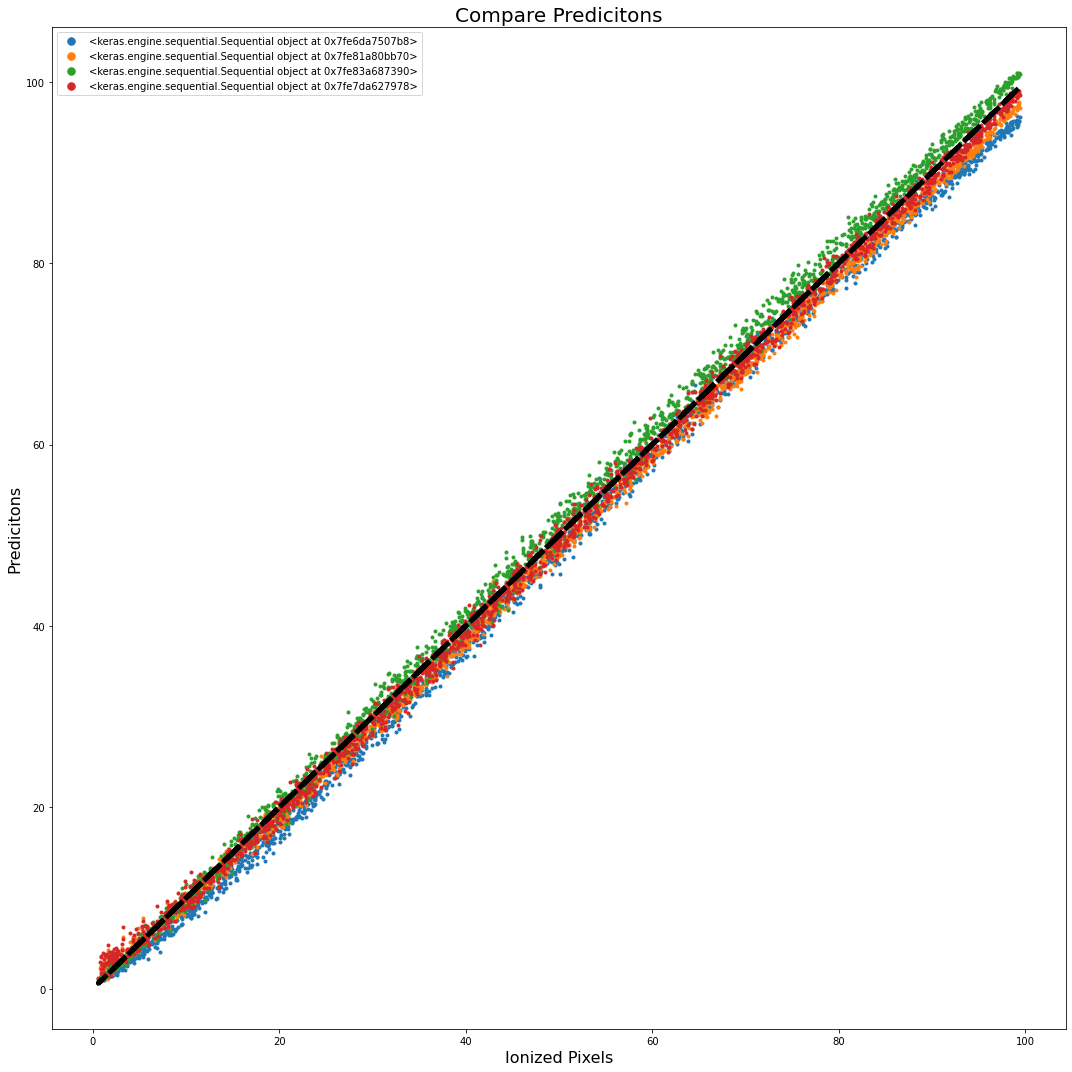

In [14]:
# make predictions                                                                                                                                                                      
prediction = []
predictions = np.empty([len(X_test),])

for m in tuner.get_best_models(num_models=num_models):
    for i in range(500):
        y_p = m.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
        prediction.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)                                                                                                 
    prediction = np.mean(np.array(prediction), axis=0)
    predictions = np.vstack((predictions, prediction))
    prediction = []
print(X_test.shape)
print(predictions.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("Compare Predicitons", size = 20)

for l in np.arange(1,5):
    plt.plot(y_test, predictions[l], '.', label = str(tuner.get_best_models(num_models=num_models)[l-1]))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predicitons", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()

In [15]:
predictions.shape

(5, 2000)

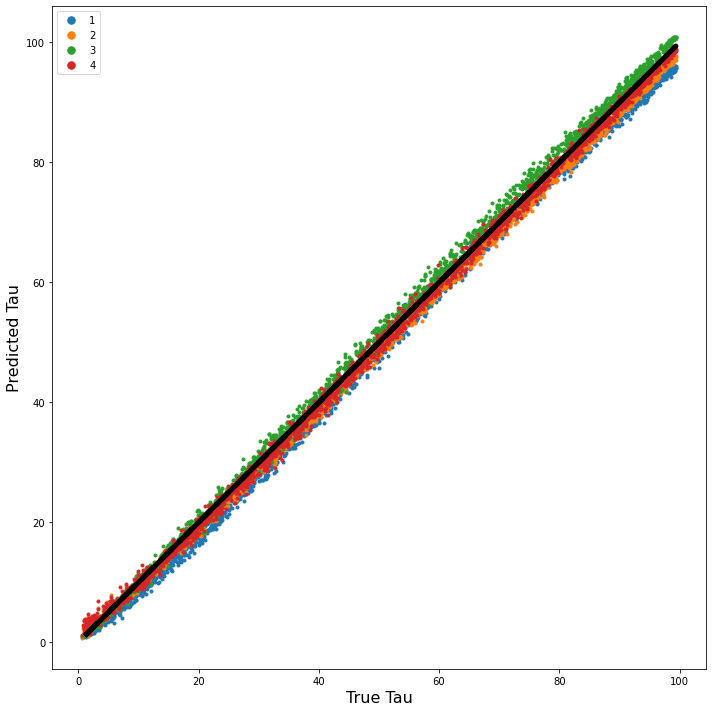

In [16]:
# compare a few of the models
plt.figure(figsize=(10,10))
for l in np.arange(1,5):
    plt.plot(y_test, predictions[l], '.', label = str(l))
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("True Tau", size = 16)
plt.ylabel("Predicted Tau", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()


### Empirical Examination of Posterior Distribution

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None


/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

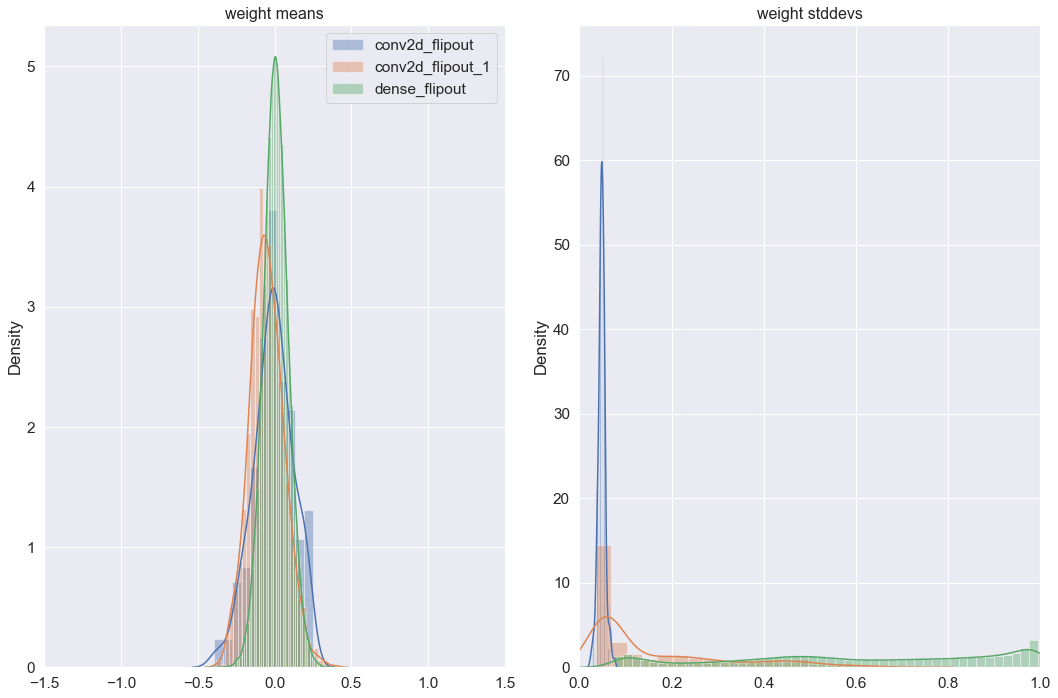

In [17]:
bnn_model = tuner.get_best_models(num_models=1)[0]
sns.set(font_scale=1.4)
def plot_weight_posteriors(names, qm_vals, qs_vals):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
    ax.set_title("weight means",size = 16 )
    ax.set_xlim([-1.5, 1.5])
    ax.legend()
    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
    ax.set_title("weight stddevs", size = 16)
    ax.set_xlim([0, 1.0])
    fig.tight_layout()
    plt.show()
    
    
names = [layer.name for layer in bnn_model.layers if "flipout" in layer.name]
qm_vals = [
    layer.kernel_posterior.mean()
    for layer in bnn_model.layers
    if "flipout" in layer.name
]
qs_vals = [
    layer.kernel_posterior.stddev()
    for layer in bnn_model.layers
    if "flipout" in layer.name
]

plot_weight_posteriors(names, qm_vals, qs_vals)

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


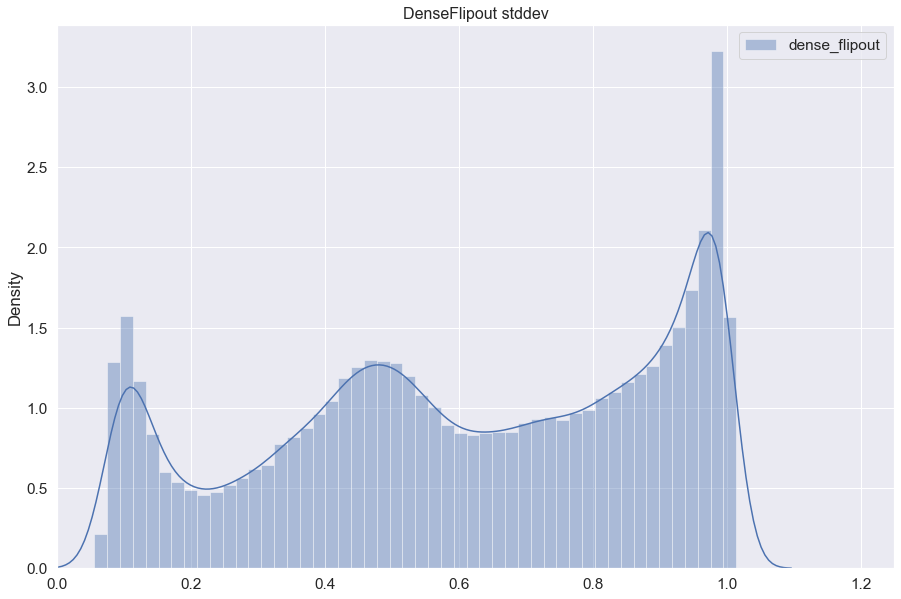

In [18]:
plt.figure(figsize=(15, 10))
sns.distplot(tf.reshape(bnn_model.layers[-1].kernel_posterior.stddev(), shape=[-1]),
             label="{}".format(str(bnn_model.layers[-1].name)))
plt.title("DenseFlipout stddev",size = 16 )
plt.xlim([0, 1.25])
plt.legend()

# Learn STD and Mean

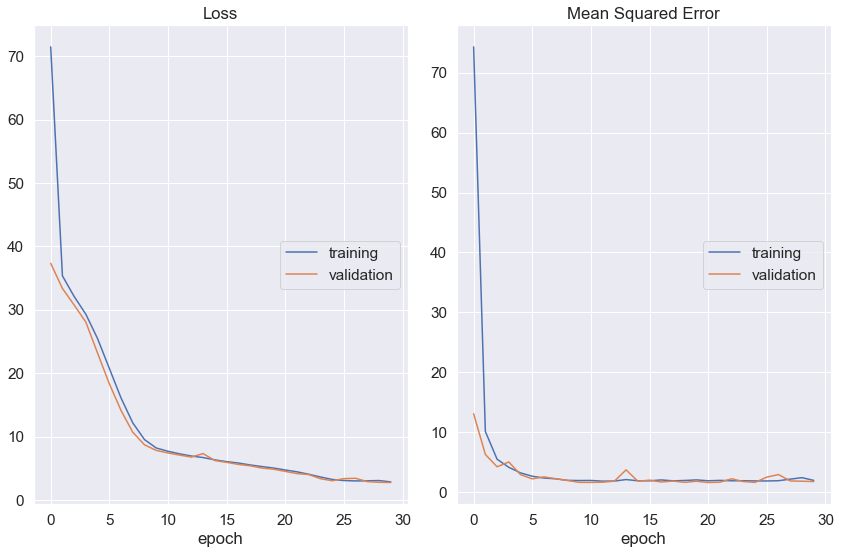

Loss
	training         	 (min:    2.852, max:   71.459, cur:    2.852)
	validation       	 (min:    2.754, max:   37.327, cur:    2.754)
Mean Squared Error
	training         	 (min:    1.808, max:   74.327, cur:    1.939)
	validation       	 (min:    1.581, max:   13.063, cur:    1.739)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_2 (Conv2DFlip (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten_1 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 1)                 246017    
_________________________________________________________________
distribution_lambda (Distrib m

In [19]:
def train_test_model():
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 16, 
                                              input_shape=(nx, ny, 1), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 8, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           #scale = 1)))
                           scale=1e-3 + tf.math.softplus(0.01 * t[..., :1]))))
    

    model.compile(optimizer= "adam", loss = "neg_log_likelihood", metrics=["mse"])
    
    plotlosses = PlotLossesKeras()

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
            epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
            callbacks=[plotlosses],
            verbose=1)
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())

    loss = model.evaluate(X_test, y_test)
    return model
                                                                                                                                                                                      
model = train_test_model()



In [20]:
# make predictions                                                                                                                                                                      
predictions = []
for i in range(500):
    y_p = model.predict(X_test).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)
    

(2000, 128, 128, 1)
(2000,)
(2000,)


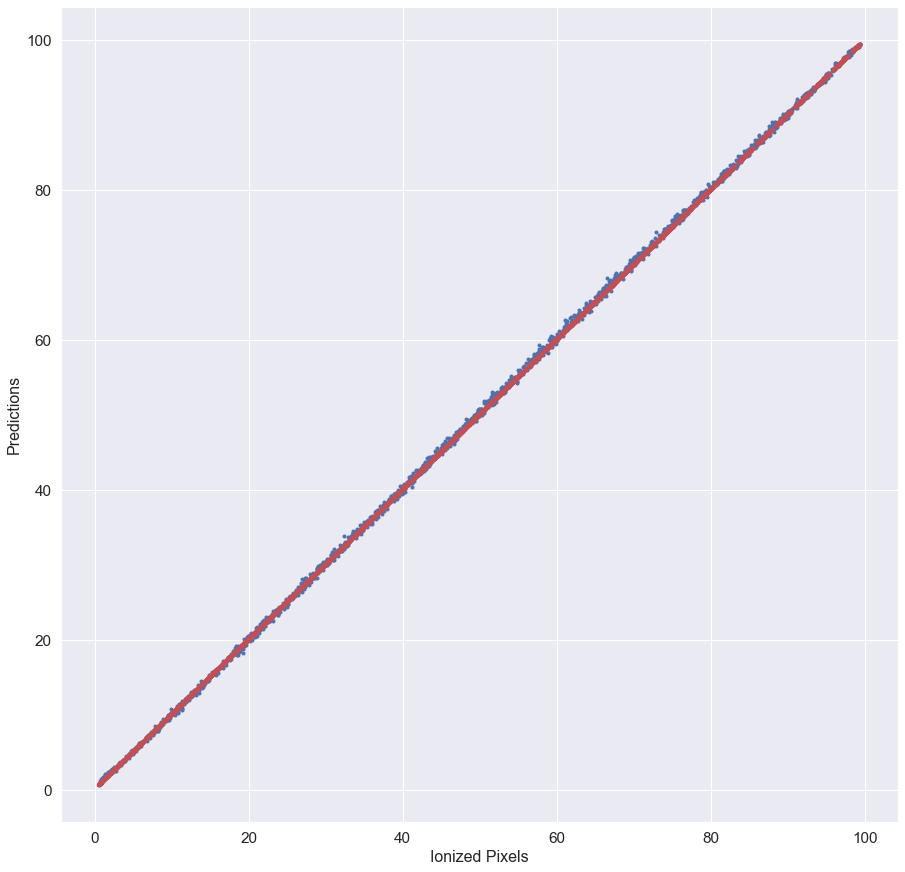

In [21]:
prediction = np.mean(np.array(predictions), axis=0)
print(X_test.shape)
print(prediction.shape)
print(y_test.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.plot(y_test, prediction, '.')
plt.plot(y_test,y_test, "r--", linewidth=5)

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

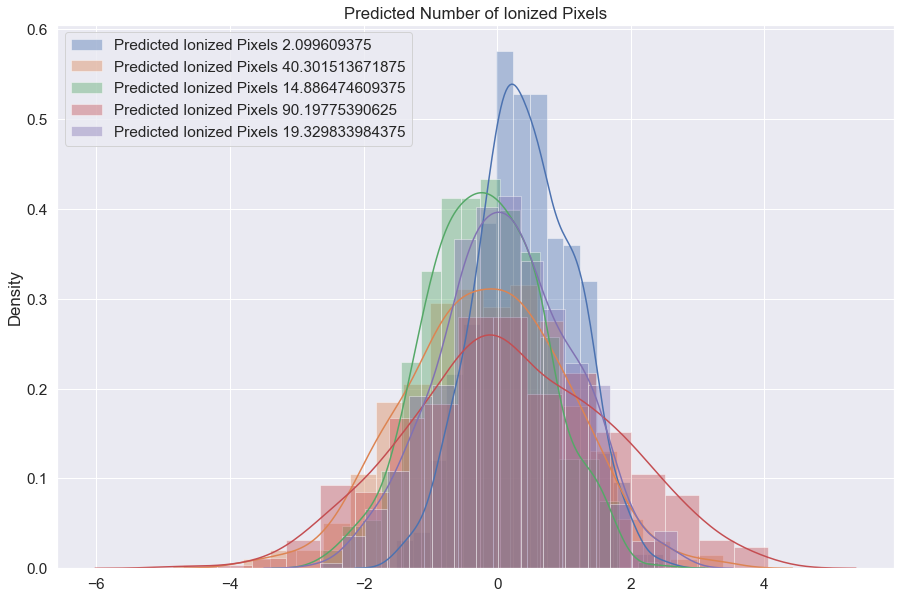

In [22]:
plt.figure(figsize=(15, 10))
plt.title("Predicted Number of Ionized {}".format("Pixels",size = 16 ))

sns.distplot(np.array(predictions)[:,0]-y_test[0],label="Predicted Ionized Pixels {}".format(str(y_test[0])))
sns.distplot(np.array(predictions)[:,1]-y_test[1],label="Predicted Ionized Pixels {}".format(str(y_test[1])))
sns.distplot(np.array(predictions)[:,2]-y_test[2],label="Predicted Ionized Pixels {}".format(str(y_test[2])))
sns.distplot(np.array(predictions)[:,3]-y_test[3],label="Predicted Ionized Pixels {}".format(str(y_test[3])))
sns.distplot(np.array(predictions)[:,4]-y_test[4],label="Predicted Ionized Pixels {}".format(str(y_test[4])))

#plt.xlim([0, 1.25])
plt.legend(markerscale=2.5)


### Plot the distribution of the predictions within a certain range.

In [23]:
np.array(predictions).shape

(500, 2000)

In [24]:
np.array(predictions)[: , np.logical_and(y_test < 60, y_test >= 50)]

array([[53.37755 , 54.397236, 54.444645, ..., 49.35369 , 56.49496 ,
        52.284607],
       [55.888893, 53.223904, 54.452137, ..., 50.076115, 54.99285 ,
        52.14295 ],
       [55.686916, 52.993183, 57.84158 , ..., 50.54757 , 55.934093,
        53.073677],
       ...,
       [53.000824, 52.048233, 53.10192 , ..., 49.622143, 55.16569 ,
        50.583607],
       [55.00615 , 53.692616, 56.892067, ..., 49.791317, 53.747852,
        53.244843],
       [54.74714 , 54.447025, 57.08514 , ..., 49.827934, 53.85106 ,
        52.032288]], dtype=float32)

In [25]:
np.array(predictions)[: , np.logical_and(y_test < 60, y_test >= 50)].shape

(500, 196)

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


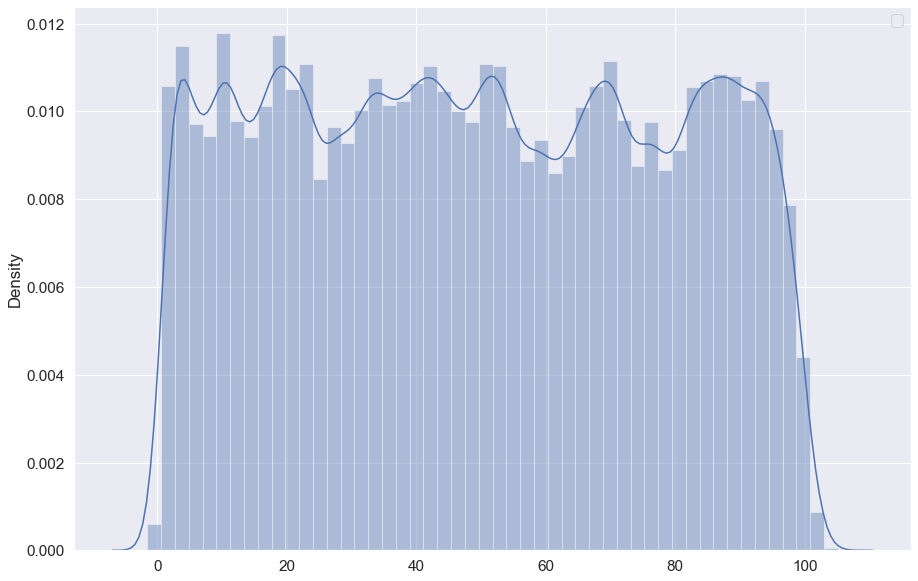

In [26]:
plt.figure(figsize=(15, 10))
sns.distplot(np.array(predictions))
plt.legend(markerscale=2.5)

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


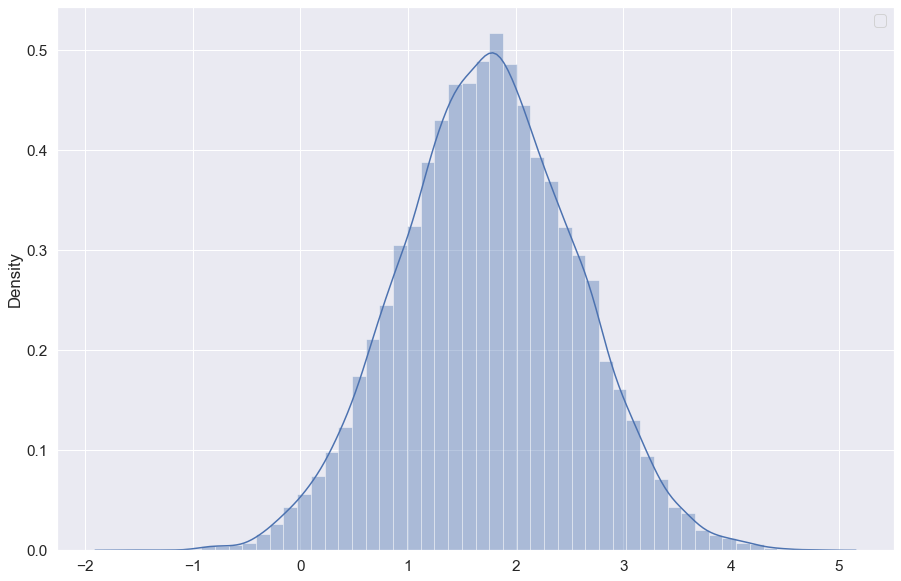

In [27]:
plt.figure(figsize=(15, 10))
sns.distplot(np.array(predictions)[: , np.logical_and(y_test < 2, y_test >= 0)])
plt.legend(markerscale=2.5)

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


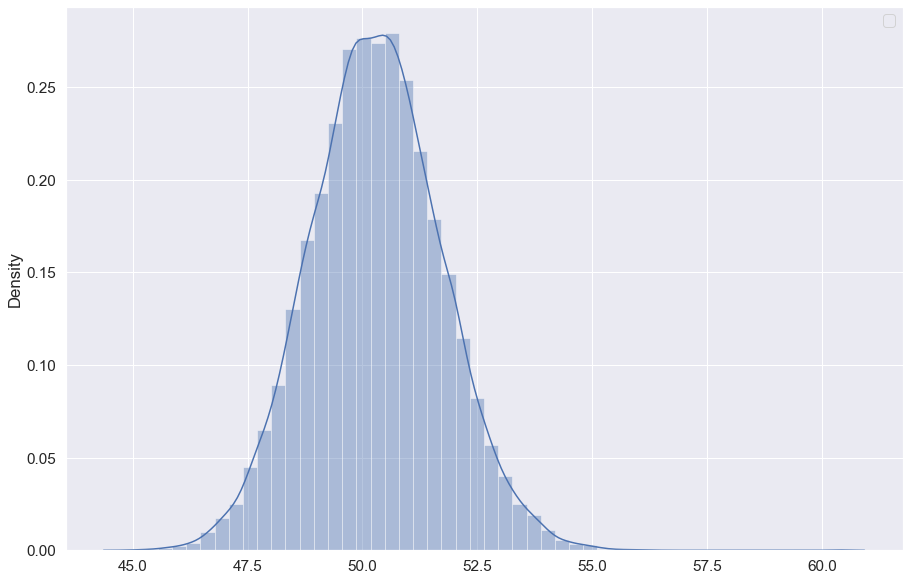

In [28]:
plt.figure(figsize=(15, 10))
sns.distplot(np.array(predictions)[: , np.logical_and(y_test < 51, y_test >= 49)])
plt.legend(markerscale=2.5)

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


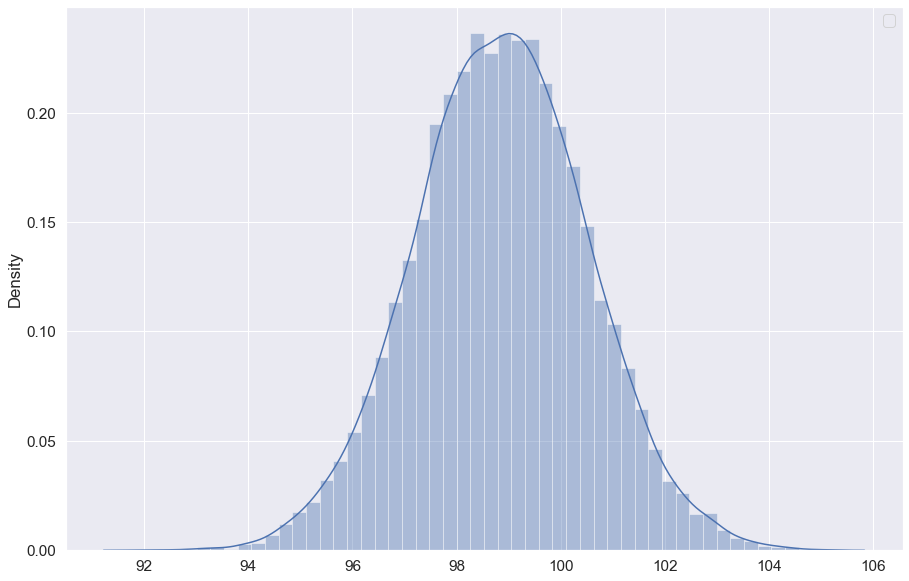

In [29]:
plt.figure(figsize=(15, 10))
sns.distplot(np.array(predictions)[: , np.logical_and(y_test < 100, y_test >= 98)])
plt.legend(markerscale=2.5)

### Error Bars

METHOD 1:  Empirical error bars for the posterior using Monte Carlo  

METHOD 2: Sigma in output layer  

In [30]:
yhat = model(X_test) # model.predict(X_test)

No handles with labels found to put in legend.


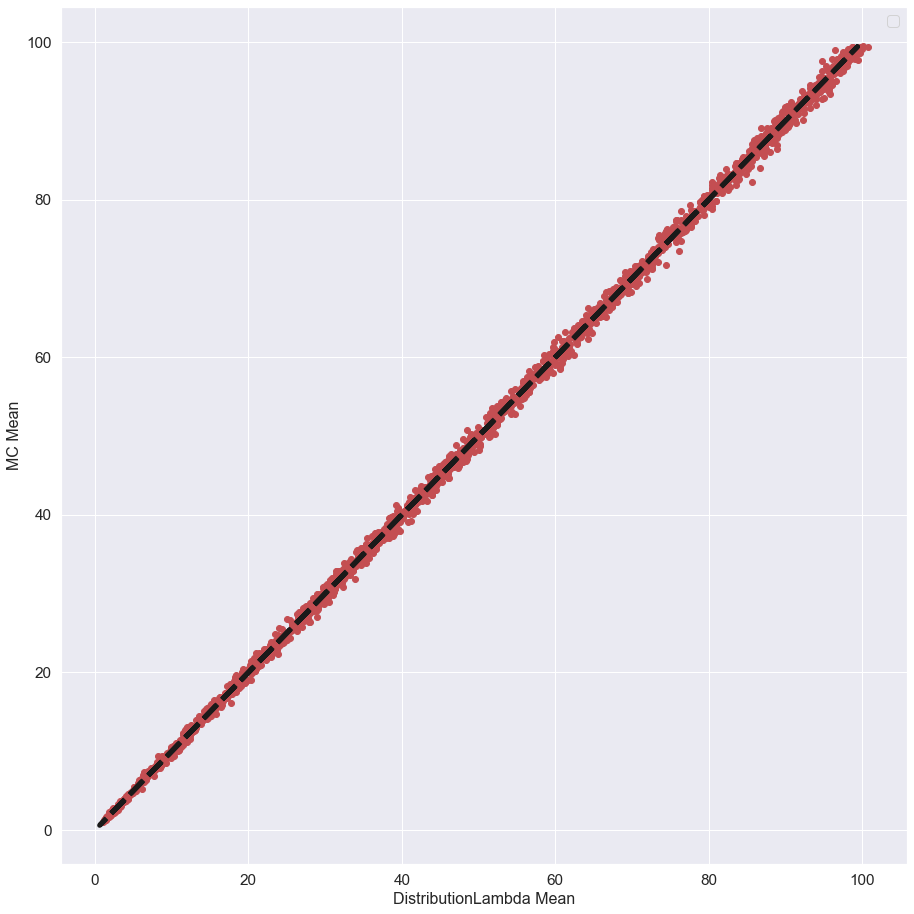

In [31]:
# Compare predicted values
plt.figure(figsize=(13,13))
plt.plot(yhat.mean(), np.mean(np.array(predictions), axis=0), 'r o', label = "")
#plt.plot(y_test, yhat.mean(), 'c *', alpha = 0.5, label = "Method 2: Sigma Output")
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("DistributionLambda Mean", size = 16)
plt.ylabel("MC Mean", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()

No handles with labels found to put in legend.


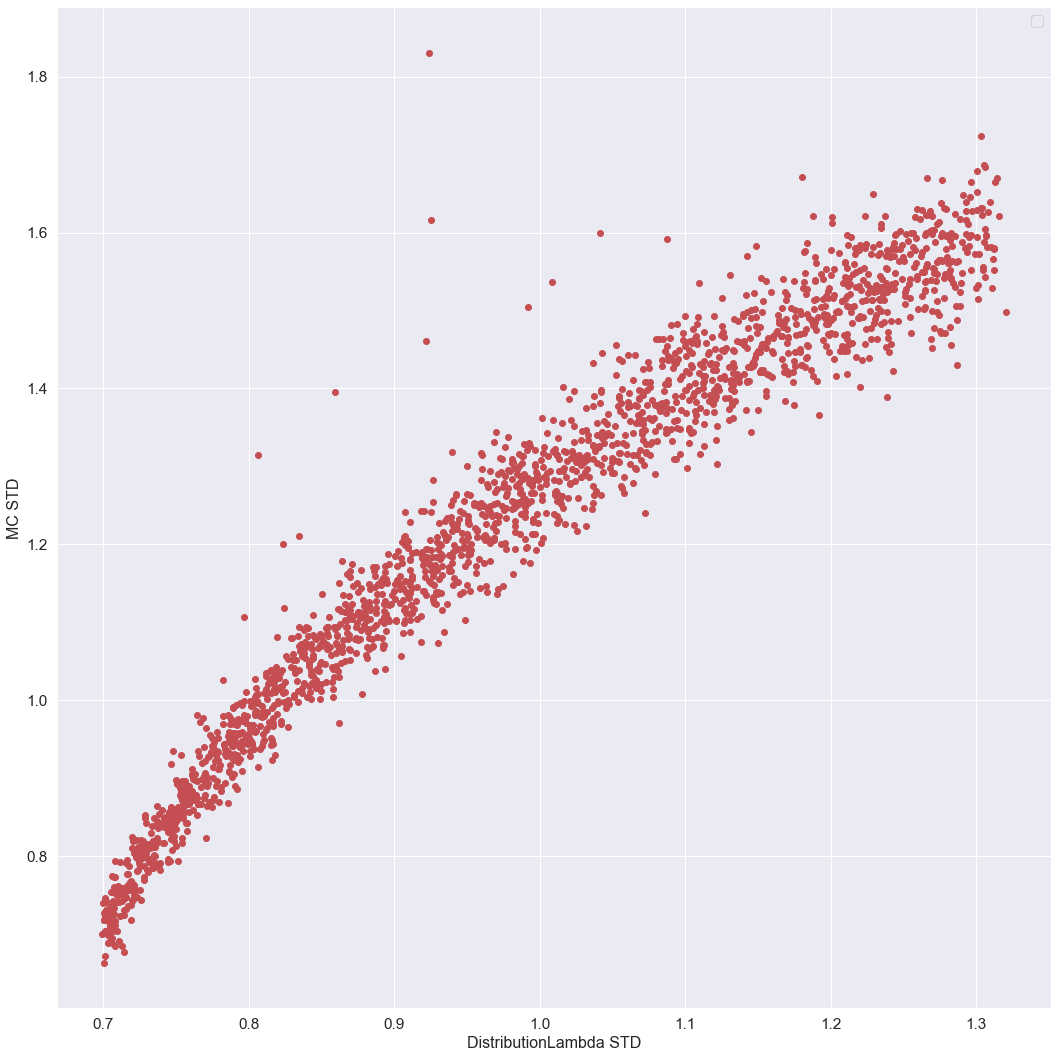

In [32]:
# Compare STDs
plt.figure(figsize=(15,15))
plt.plot(yhat.stddev(), np.std(np.array(predictions), axis=0), 'r o', label = "")

plt.xlabel("DistributionLambda STD", size = 16)
plt.ylabel("MC STD", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()

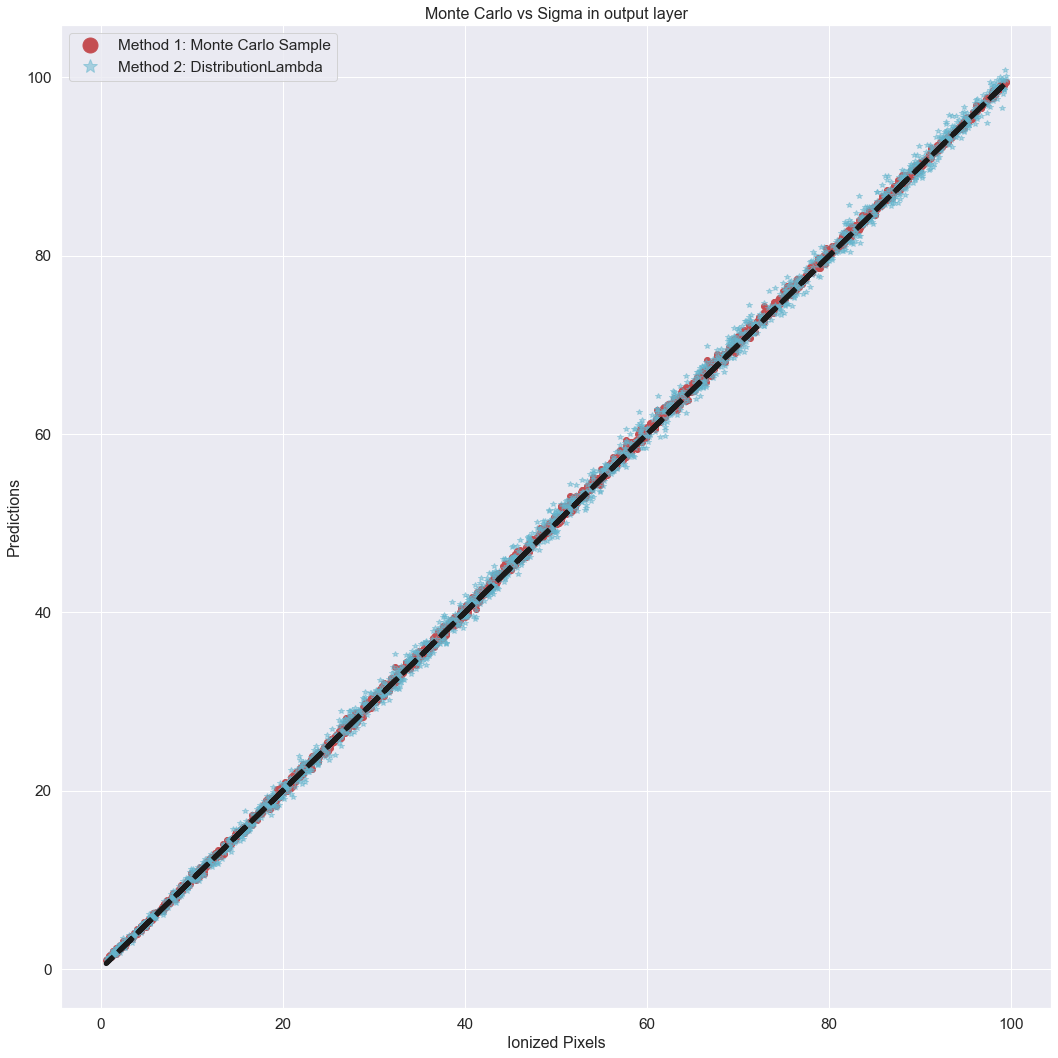

In [33]:
# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("Monte Carlo vs Sigma in output layer", size = 16)

plt.plot(y_test, np.mean(np.array(predictions), axis=0), 'r o', label = "Method 1: Monte Carlo Sample")
plt.plot(y_test, yhat.mean(), 'c *', alpha = 0.5, label = "Method 2: DistributionLambda")
plt.plot(y_test,y_test, "k--", linewidth=5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictions", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()

In [34]:
y_test.shape

(2000,)

In [35]:
yhat.mean()

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[ 2.1828384],
       [41.397736 ],
       [14.929361 ],
       ...,
       [ 6.9238534],
       [ 5.87779  ],
       [81.089325 ]], dtype=float32)>

In [36]:
(yhat.mean().numpy()[0::10]-yhat.stddev().numpy()[0::10]).shape

(200, 1)

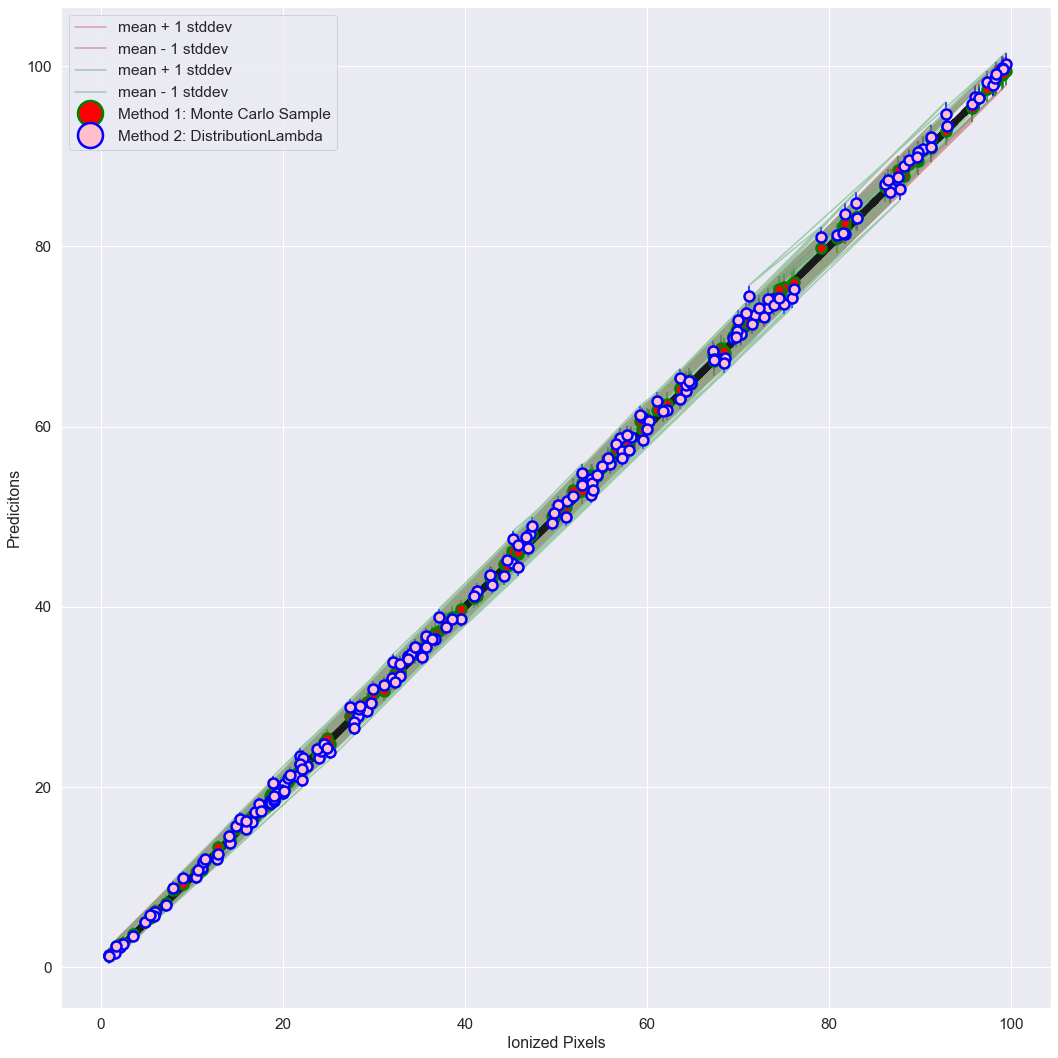

In [37]:
# Plot Error
plt.figure(figsize=(15,15))
#plt.title("Error bars for the posterior using Monte Carlo vs Sigma in output layer", size = 16)

plt.errorbar(y_test[0::10], np.mean(np.array(predictions), axis=0)[0::10], yerr=np.std(predictions, axis=0)[0::10], marker='.', 
             mfc='red', mec='green', c='green', mew=2.5, ms=20, ls='', label="Method 1: Monte Carlo Sample")
plt.errorbar(y_test[0::10], yhat.mean().numpy()[0::10,0], yerr=yhat.stddev().numpy()[0::10,0], marker='.', 
             mfc='pink', mec='blue', c='blue', mew=2.5, ms=20, ls='', label="Method 2: DistributionLambda")

plt.plot(y_test[0::10],np.mean(np.array(predictions), axis=0)[0::10]+np.std(predictions, axis=0)[0::10], 'r-', alpha=0.5,
         label='mean + 1 stddev'
        )
plt.plot(y_test[0::10],np.mean(np.array(predictions), axis=0)[0::10]-np.std(predictions, axis=0)[0::10], 'r-', alpha=0.5, 
         label='mean - 1 stddev'
        )

plt.plot(y_test[0::10],yhat.mean().numpy()[0::10]+yhat.stddev().numpy()[0::10], 'g-', alpha=0.5, 
         label='mean + 1 stddev'
        )
plt.plot(y_test[0::10],yhat.mean().numpy()[0::10]-yhat.stddev().numpy()[0::10], 'g-', alpha=0.5, 
         label='mean - 1 stddev'
        )

#plt.fill_between(y_test[0::10],  
#                 yhat.mean().numpy()[0::10,0]-yhat.stddev().numpy()[0::10,0], 
#                 yhat.mean().numpy()[0::10,0]+yhat.stddev().numpy()[0::10,0],
#                 color='blue', alpha=0.5,
#                )

plt.plot(y_test,y_test, "k--", linewidth=7)
plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predicitons", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()

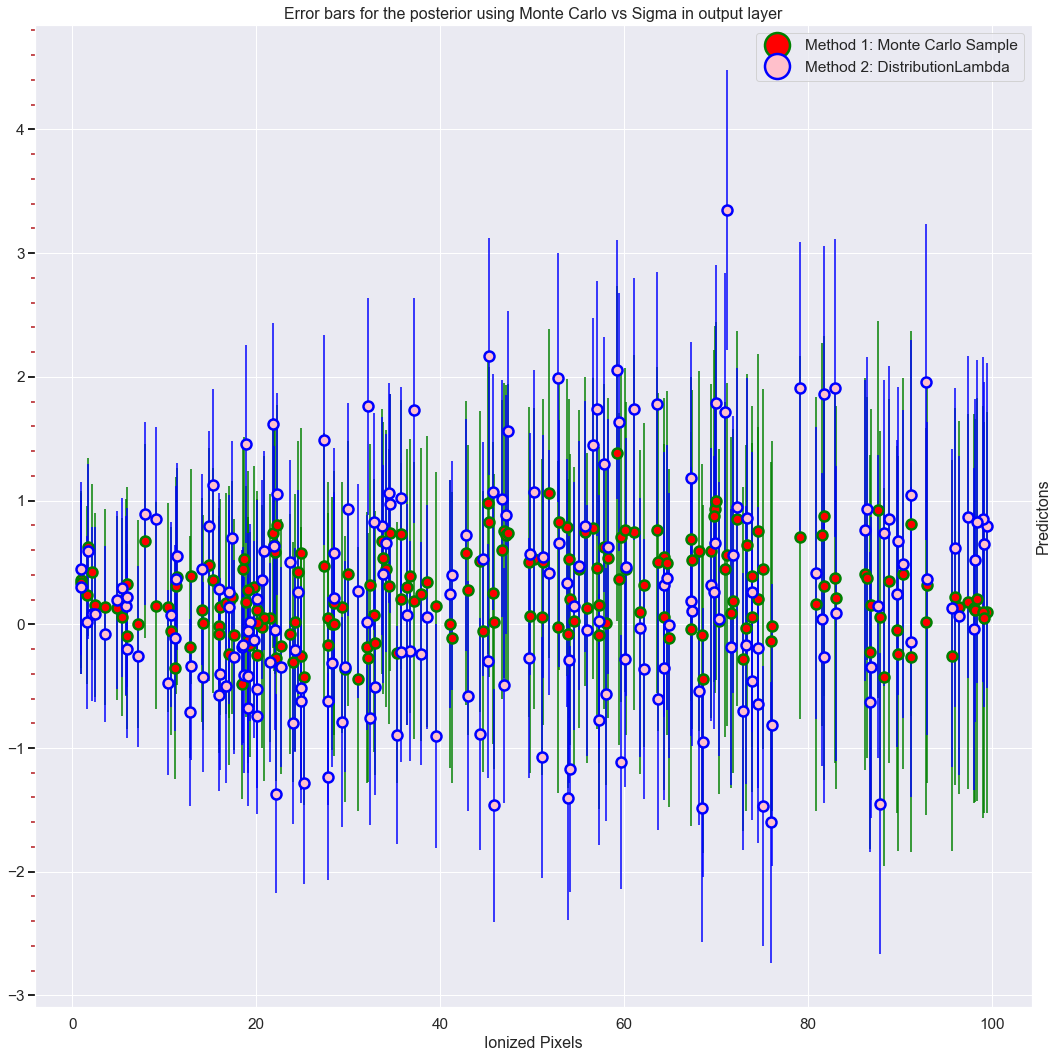

In [38]:
# Plot Error

f=plt.figure(figsize=(15,15))

ax = f.add_subplot(111)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("right")

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='r')

plt.title("Error bars for the posterior using Monte Carlo vs Sigma in output layer", size = 16)

ax.errorbar(y_test[0::10], (np.mean(np.array(predictions), axis=0)-y_test)[0::10], yerr=np.std(predictions, axis=0)[0::10], marker='.', 
             mfc='red', mec='green', c='green', mew=2.5, ms=20, ls='', label="Method 1: Monte Carlo Sample")
ax.errorbar(y_test[0::10], yhat.mean().numpy()[0::10,0]-y_test[0::10], yerr=yhat.stddev().numpy()[0::10,0], marker='.', 
             mfc='pink', mec='blue', c='blue', mew=2.5, ms=20, ls='', label="Method 2: DistributionLambda")

#ax = f.add_subplot(111)
#ax.yaxis.tick_right()
#ax.yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))
#ax.plot(y_test,y_test-y_test, "k--", linewidth=7)
#plt.grid(axis = 'y', color = 'green', linestyle = '--', linewidth = 0.5)

plt.xlabel("Ionized Pixels", size = 16)
plt.ylabel("Predictons", size = 16)
plt.legend(markerscale=2.5)
plt.tight_layout()

In [39]:
model.weights

[<tf.Variable 'conv2d_flipout_2/kernel_posterior_loc:0' shape=(3, 3, 1, 16) dtype=float32, numpy=
 array([[[[-0.16880755, -0.22166766, -0.03905748, -0.00718956,
           -0.10838768, -0.3188625 , -0.2616091 , -0.21717235,
           -0.26389244, -0.21531145, -0.21760531, -0.21035185,
           -0.16187386, -0.2546688 , -0.12072642, -0.22882009]],
 
         [[-0.28505948, -0.26725072,  0.06763396, -0.00864095,
           -0.145651  , -0.09639407, -0.18989936, -0.10102362,
           -0.13420266, -0.16693665, -0.11476861, -0.26591045,
           -0.25703102, -0.27279457, -0.25324774, -0.2080883 ]],
 
         [[-0.19830666, -0.17606393, -0.03246984, -0.19150189,
           -0.12800716, -0.18227796, -0.27490878, -0.13927262,
           -0.26573023, -0.239596  , -0.14671859, -0.31227344,
           -0.20439105, -0.2718553 , -0.13288017, -0.25019208]]],
 
 
        [[[-0.19104306, -0.17843996, -0.01110299,  0.1378154 ,
           -0.22681697,  0.00273825, -0.26646602, -0.15512958,
     

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


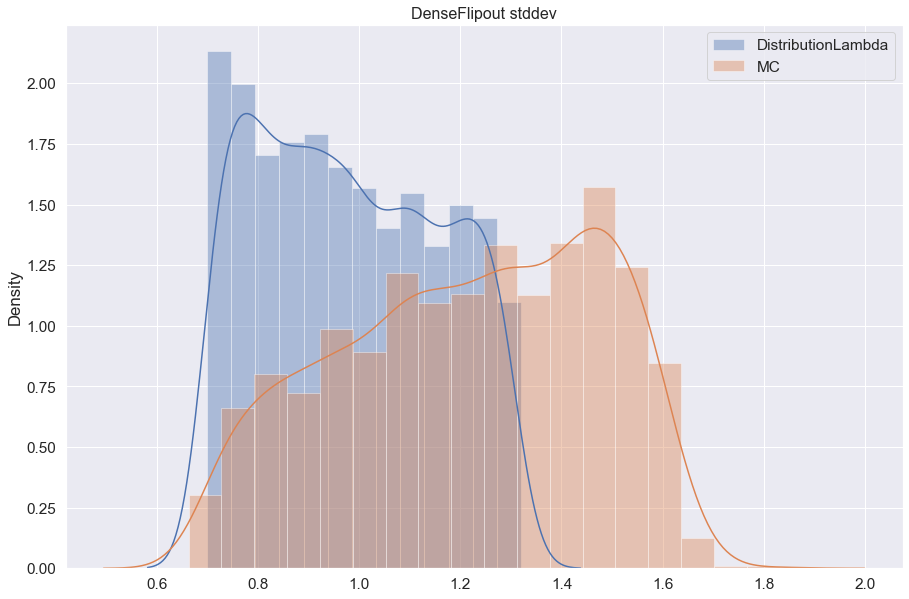

In [40]:
plt.figure(figsize=(15, 10))
sns.distplot(yhat.stddev(),label="DistributionLambda")
sns.distplot(np.std(np.array(predictions), axis=0), label= "MC")
plt.title("DenseFlipout stddev",size = 16 )
#plt.xlim([0, 1.25])
plt.legend()

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

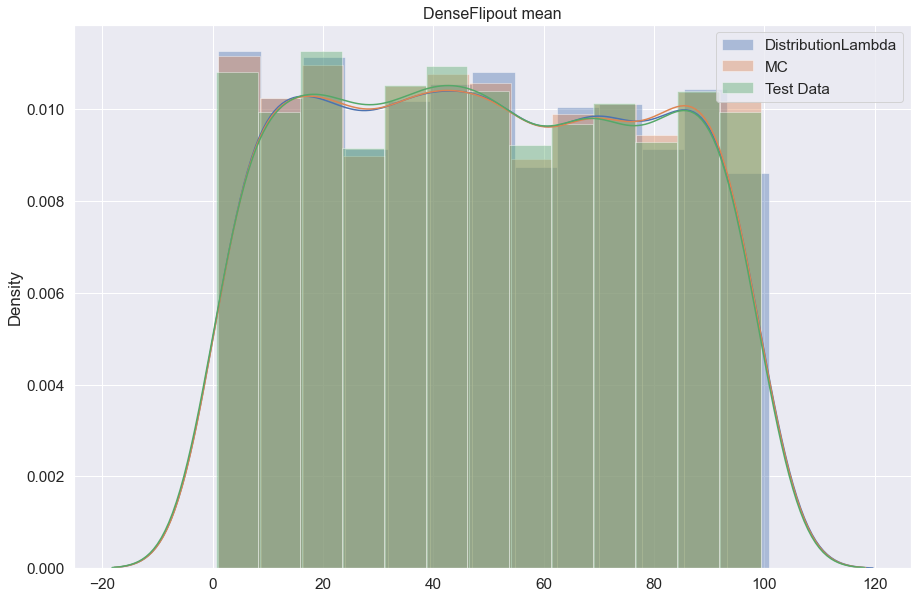

In [41]:
plt.figure(figsize=(15, 10))
sns.distplot(yhat.mean(),label="DistributionLambda")
sns.distplot(np.mean(np.array(predictions), axis=0), label= "MC")
sns.distplot(y_test, label= "Test Data")
plt.title("DenseFlipout mean",size = 16 )
#plt.xlim([0, 1.25])
plt.legend()

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
Total params: 248,633
Trainable params: 248,633
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      304       
_________________________

IndexError: list index out of range

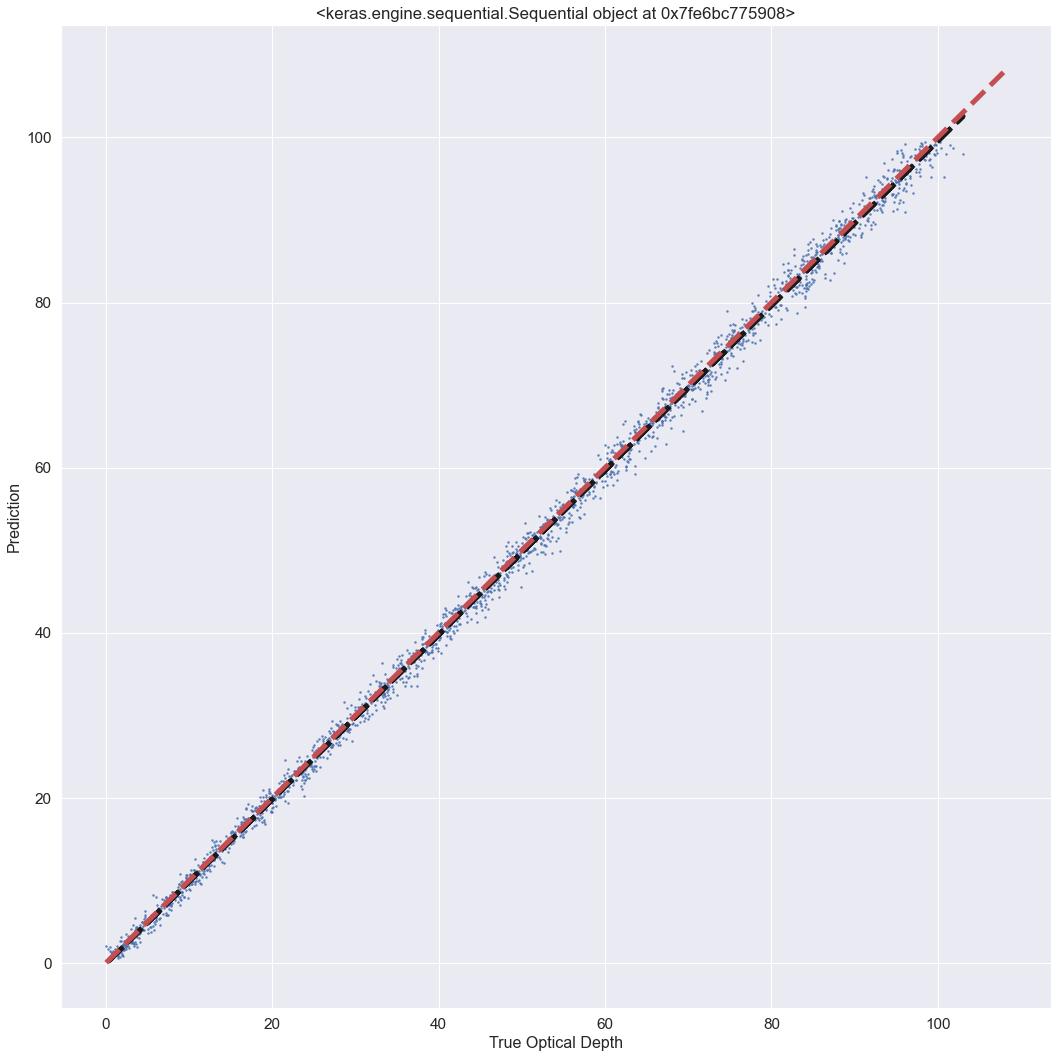

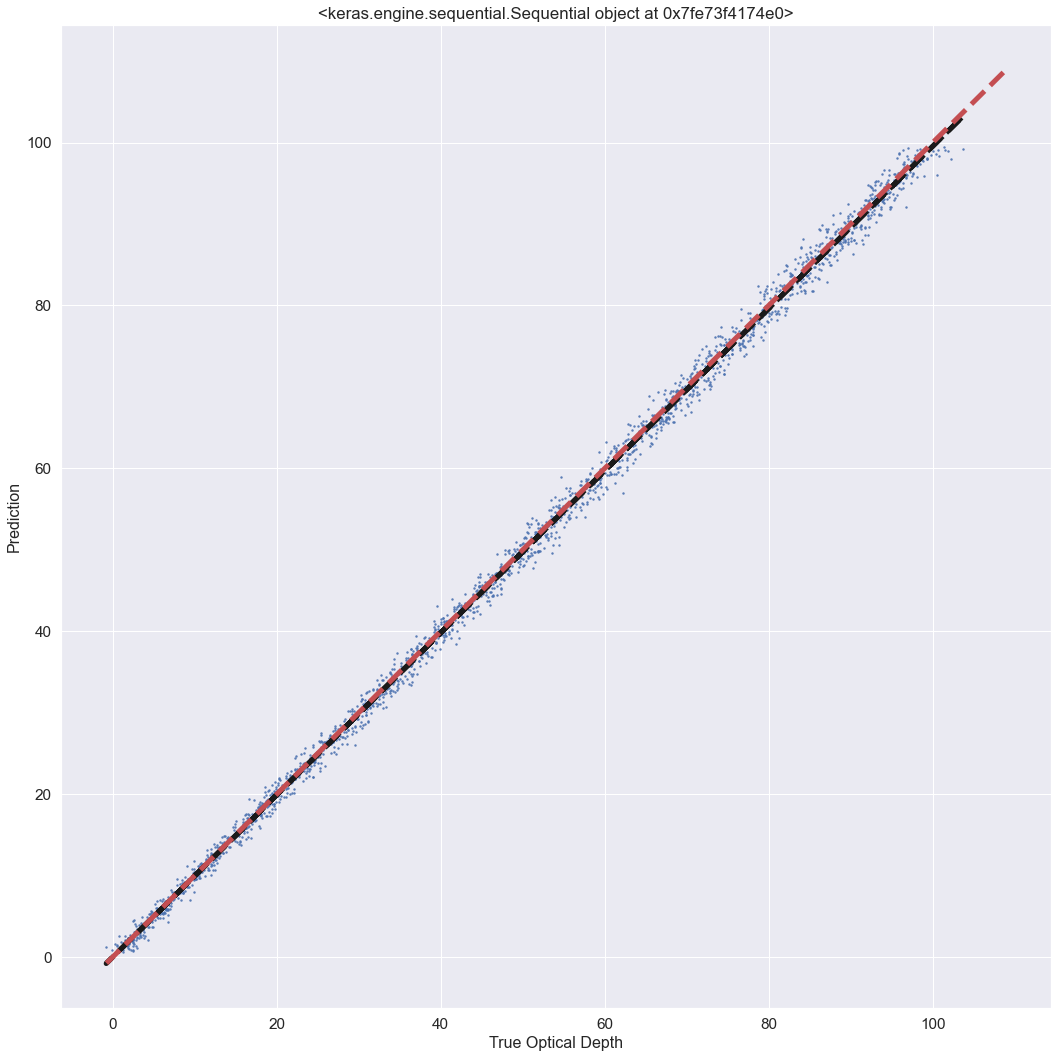

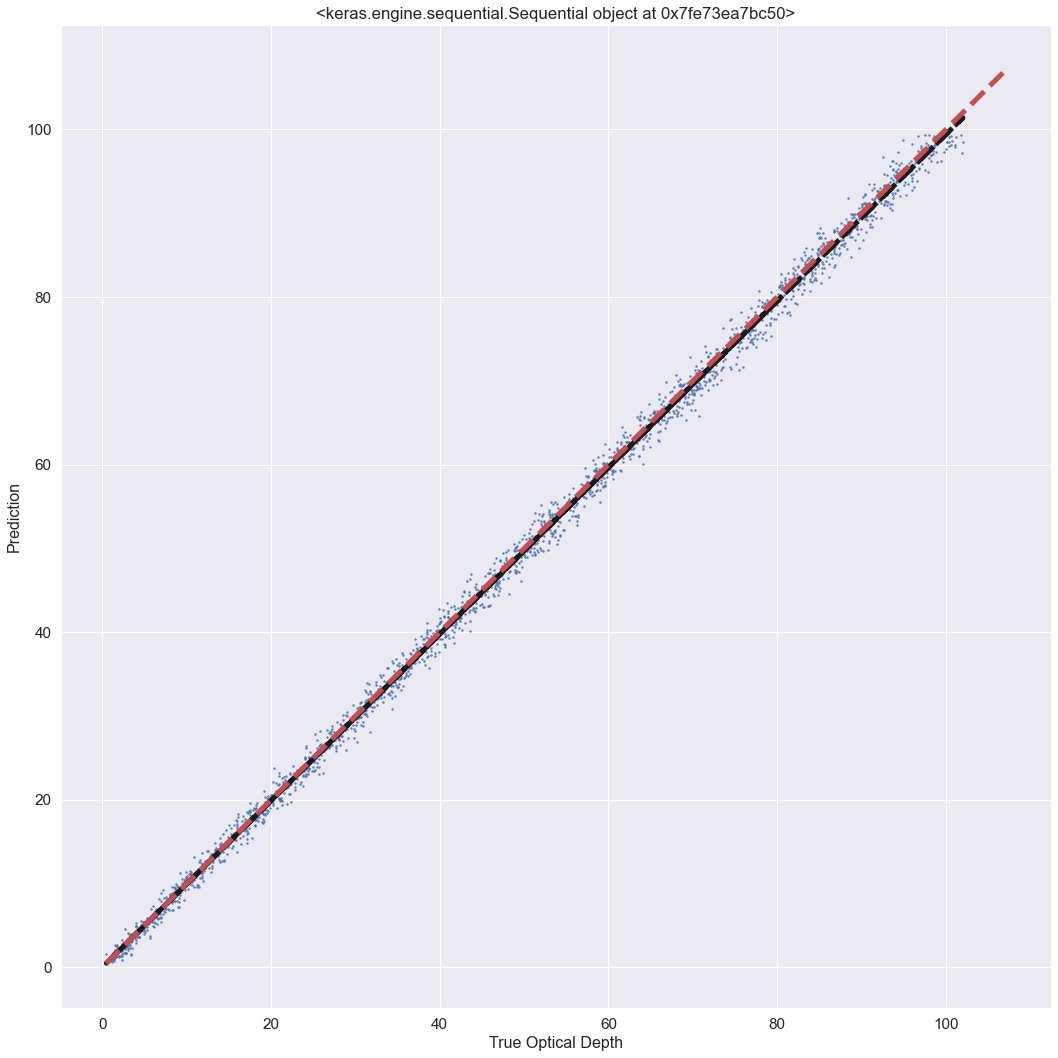

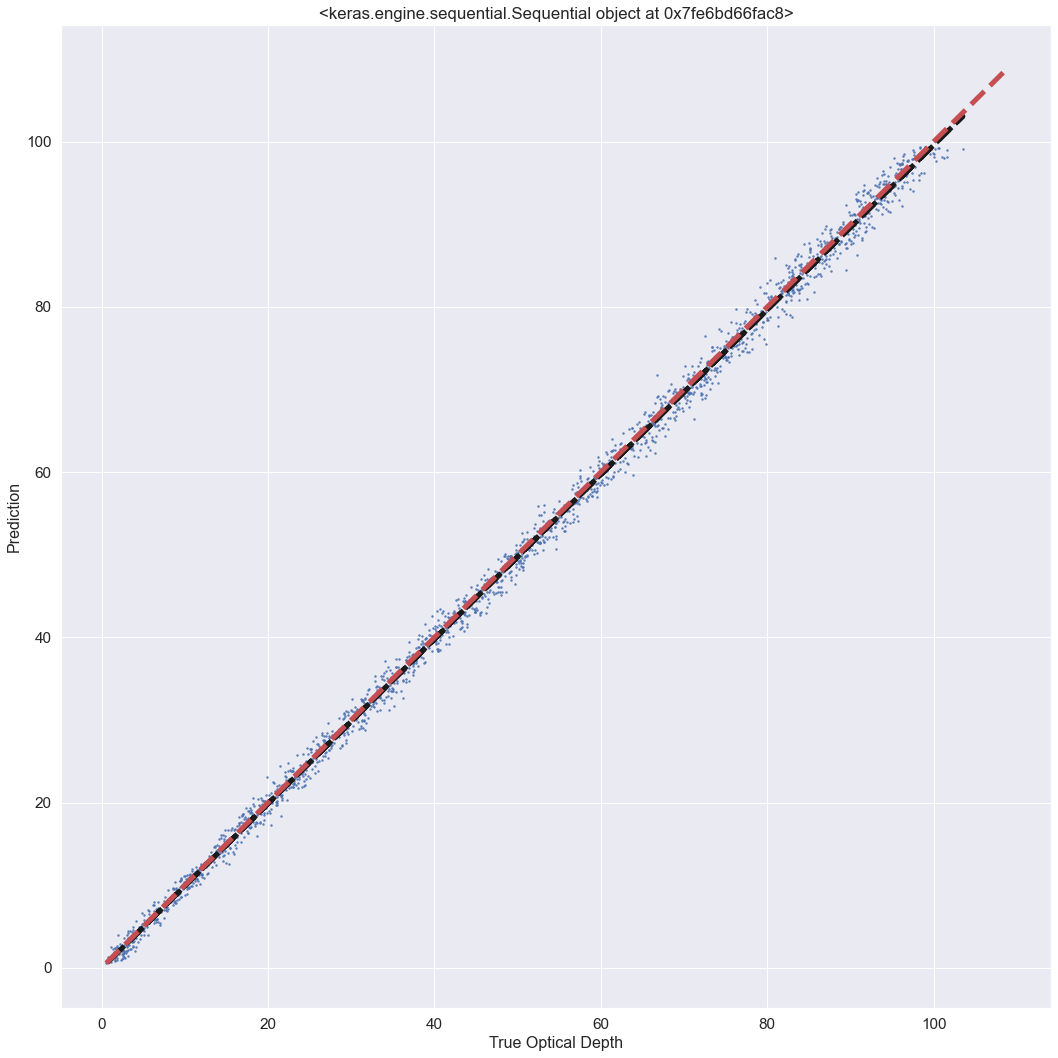

In [42]:
coefficients = []

fp = open(outputdir+"bestmodel_estimated_coefficients_1.log", 'w+')
fp.write("b_0, b_1 \n")

if __name__ == "__main__":

    for p in np.arange(len(tuner.get_best_models(num_models=20))):
        main(x=np.array(predictions)[p], y=y_test, labelname=str(tuner.get_best_models(num_models=15)[p-1]))
    fp.close()
    #statistics_plot_coef(coefficient=coefficients)
    #statistics_plot_dev(coefficient=coefficients)

### Empirical Examination of Posterior Distribution

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

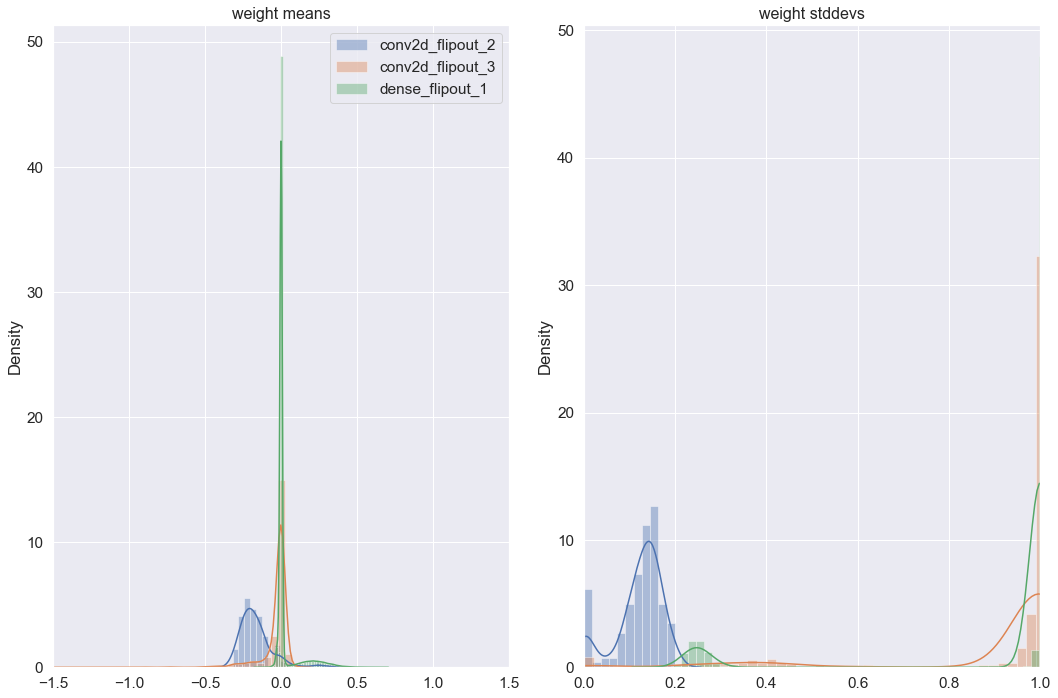

In [43]:
bnn_model = model#tuner.get_best_models(num_models=1)[0]
sns.set(font_scale=1.4)
def plot_weight_posteriors(names, qm_vals, qs_vals):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
    ax.set_title("weight means",size = 16 )
    ax.set_xlim([-1.5, 1.5])
    ax.legend()
    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
    ax.set_title("weight stddevs", size = 16)
    ax.set_xlim([0, 1.0])
    fig.tight_layout()
    plt.show()
    
    
names = [layer.name for layer in bnn_model.layers if "flipout" in layer.name]
qm_vals = [
    layer.kernel_posterior.mean()
    for layer in bnn_model.layers
    if "flipout" in layer.name
]
qs_vals = [
    layer.kernel_posterior.stddev()
    for layer in bnn_model.layers
    if "flipout" in layer.name
]

plot_weight_posteriors(names, qm_vals, qs_vals)

In [44]:
qs_vals

[<tf.Tensor: shape=(3, 3, 1, 16), dtype=float32, numpy=
 array([[[[0.10205555, 0.1075968 , 0.00244435, 0.00560213, 0.10033888,
           0.18835716, 0.18494138, 0.12087571, 0.17022012, 0.08291304,
           0.14884818, 0.13773276, 0.13275537, 0.1352878 , 0.14001083,
           0.10446512]],
 
         [[0.17754818, 0.15171495, 0.00224615, 0.00882184, 0.12436222,
           0.10117033, 0.15358455, 0.10049451, 0.11241512, 0.1580143 ,
           0.12971367, 0.1935217 , 0.12148892, 0.152653  , 0.14426552,
           0.16893007]],
 
         [[0.11509445, 0.11228924, 0.00380789, 0.04841932, 0.1398299 ,
           0.11043414, 0.19264312, 0.11208896, 0.11881739, 0.16051947,
           0.11146052, 0.16717573, 0.1207756 , 0.12862666, 0.12925984,
           0.14086677]]],
 
 
        [[[0.11008705, 0.13724619, 0.00134234, 0.00531065, 0.15990743,
           0.09709205, 0.13433008, 0.1106454 , 0.16180362, 0.14913085,
           0.10213879, 0.14863646, 0.11442769, 0.16138007, 0.19961125,
        

In [45]:
tf.reshape(bnn_model.layers[-2].kernel_posterior.stddev(), shape=[-1])

<tf.Tensor: shape=(123008,), dtype=float32, numpy=
array([0.98468935, 0.99999917, 1.        , ..., 1.        , 1.        ,
       1.        ], dtype=float32)>

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


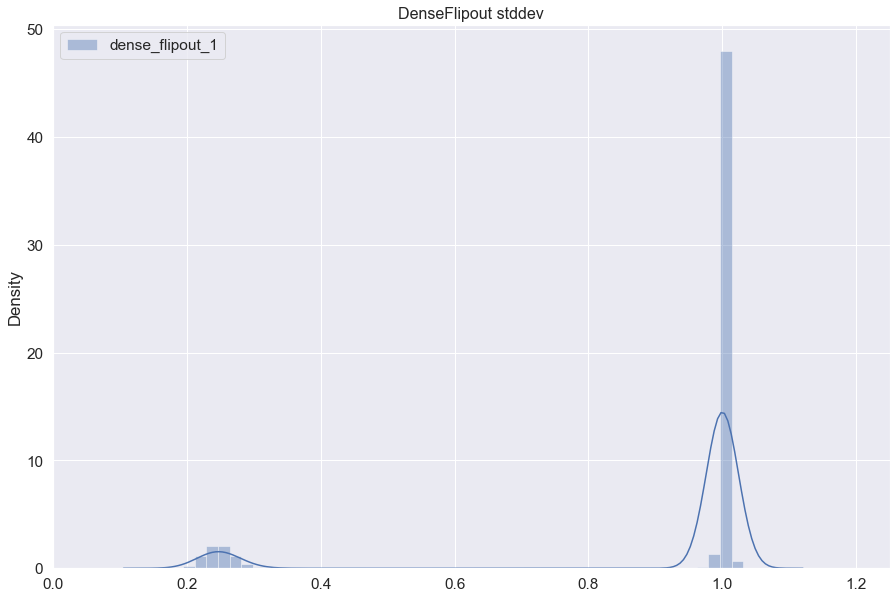

In [46]:
plt.figure(figsize=(15, 10))
sns.distplot(tf.reshape(bnn_model.layers[-2].kernel_posterior.stddev(), shape=[-1]),
             label="{}".format(str(bnn_model.layers[-2].name)))
plt.title("DenseFlipout stddev",size = 16 )
plt.xlim([0, 1.25])
plt.legend()